# Dependencies

In [ ]:
!python -c 'import tensorflow; print(tensorflow.__version__)'

2020-07-20 14:22:31.808763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2.2.0


In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 27kB/s 
     |████████████████████████████████| 3.8MB 41.2MB/s 
     |████████████████████████████████| 512kB 40.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=236c36466c1d0069f72052aad1217382e084dddef58df0a29eabf5259d0e6028
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras import regularizers, constraints

Using TensorFlow backend.


# GAN

In [3]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 128
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

#-------------------------------------------------------------------------
    z = Input(shape=(self.latent_dim,))
    print('--------------------------------')
    print('This is z :' , z)
    print('This is z.shape :' , z.shape)
        

#--------------------------------------------------------------------------
    img = self.generator(z)
    print('--------------------------------')
    print('Image shape: ', img.shape)

    self.discriminator.trainable = False

#-----------------------------------------------------------------------------
    validity = self.discriminator(img)
    print('--------------------------------')
    print('Validity: ', validity)
    print('--------------------------------')
    print('Type of validity:', type(validity))

    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    
  def build_generator(self):
    model = Sequential()
    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    model.summary()
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    return Model(noise, img)
        
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    
#-------------------------------------------------------------------------------------
 #   model.add(MinibatchDiscrimination(4, 4, input_dim = (256,)))
 #   model.add(Reshape((16,16)))
 #   model.add(Flatten())
#------------------------------------------------------------------------------------

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)


  #def train(self, epochs, batch_size=128, sample_interval=60):
  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    
#-------------------------------------------------------------------
    #print('x train [0]:', X_train[0] , ' its shape:', X_train[0].shape) ---------> 28*28

    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)
    #print('new x train[0] :', X_train[0] , ' its shape:', X_train[0].shape) ------> 28*28*1
      
      
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    print('--------------------------------')
    print('valid.shape inside training:', valid.shape)
    print('--------------------------------')
    print('fake.shape inside training:', fake.shape)


    for epoch in range(epochs):
      #-------------------------------------------------------------------------
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      print('--------------------------------')
      print("this is idx.shape: ", idx.shape)

      imgs = X_train[idx]
      print('--------------------------------')
      #print('imgs.shape:', imgs.shape)
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      #print('noise:', noise)
      gen_imgs = self.generator.predict(noise)
      #print('gen_imgs', gen_imgs)
      #print('hello')
          
      #-------------------------------------------------------------------------------------------
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      print('--------------------------------')
      print('d loss real', d_loss_real)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      print('--------------------------------')
      print('d loss fake', d_loss_fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      print('--------------------------------')
      print(' d_ loss ' , d_loss)
          
# ------------------------------------------------------------------------------------------------
 #its shape --> zeros
      #mean_samples =   np.zeroes((1, self.latent_dim))
      #for i in range(1, batch_size):
      #  other_samples_noise = np.random.normal(0, 1, (1, self.latent_dim))
      #  mean_samples = mean_samples + noise
      #mean_samples = mean_samples/(batch_size-1)

      #first_sample_noise = noise = np.random.normal(0, 1, (1, self.latent_dim))

      #g_discrimination = 


# --------------------------------------------------------------------------------------------------
 #its shape --> zeros (initialize)
      #mean_samples =   np.zeroes((1, self.latent_dim))
      #max_discrimination = vector
     
      #other_samples_noise = np.random.normal(0, 1, ((batch_size -1), self.latent_dim))
      #mean_samples = other_samples_noise #(jam besham ruye sutun)
      #mean_samples = mean_samples/(batch_size-1) #taghsim beshan be tedad vas miyangin gereftan
        
      #first_sample_noise = np.random.normal(0, 1, (1, self.latent_dim))
      #discrimination = first_sample_noise - mean_samples

      #fake_generated_sample_1 = self.generator.predict(first_sample_noise)
      #fake_generated_sample_2 = self.generator.predict(discrimination)

      #use mean squer for calculating the distance
      #discrimination = fake_generated_sample_1 - fake_generated_sample_2

      #g_discrimination = 
# ------------------------------------------------------------------------------------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

# ------------------------------------------------------------------------------------------------
      fake_images = self.generator.predict(noise)
      g_loss_discrimination = 1/(np.linalg.norm(fake_images))

      print('first loss discrimination : ', g_loss_discrimination)

      while g_loss_discrimination < 0.001:
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        fake_images = self.generator.predict(noise)
        g_loss_discrimination = 1/(np.linalg.norm(fake_images))

      print('loss discrimination after while :', g_loss_discrimination)
      
      # generator train on batch (generator with two out put)
# ------------------------------------------------------------------------------------------------

      g_loss = self.combined.train_on_batch(noise, valid)


# ------------------------------------------------------------------------------------------------
      #g_loss_new = g_loss * g_loss_discrimination
      #print('g_loss_new:' , g_loss_new)
# ------------------------------------------------------------------------------------------------


      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
      #fig.savefig("images/%d.png" % epoch)
      plt.close()

In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=128, sample_interval=1000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params:

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


--------------------------------
d loss real [0.4675552, 0.8984375]
--------------------------------
d loss fake [0.70773274, 0.359375]
--------------------------------
 d_ loss  [0.587644   0.62890625]
first loss discrimination :  0.015265788616719598
loss discrimination after while : 0.015265788616719598
0 [D loss: 0.587644, acc.: 62.89%] [G loss: 0.640791]
--------------------------------
this is idx.shape:  (128,)
--------------------------------
--------------------------------
d loss real [0.044743687, 1.0]
--------------------------------
d loss fake [0.66083574, 0.671875]
--------------------------------
 d_ loss  [0.3527897 0.8359375]
first loss discrimination :  0.014719236008404447
loss discrimination after while : 0.014719236008404447
1 [D loss: 0.352790, acc.: 83.59%] [G loss: 0.638444]
--------------------------------
this is idx.shape:  (128,)
--------------------------------
--------------------------------
d loss real [0.01806425, 1.0]
--------------------------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
--------------------------------
d loss fake [0.7311403, 0.296875]
--------------------------------
 d_ loss  [0.62010026 0.640625  ]
first loss discrimination :  0.004328575440565441
loss discrimination after while : 0.004328575440565441
583 [D loss: 0.620100, acc.: 64.06%] [G loss: 0.763199]
--------------------------------
this is idx.shape:  (128,)
--------------------------------
--------------------------------
d loss real [0.53311414, 0.9609375]
--------------------------------
d loss fake [0.740342, 0.2421875]
--------------------------------
 d_ loss  [0.63672805 0.6015625 ]
first loss discrimination :  0.004327284713359646
loss discrimination after while : 0.004327284713359646
584 [D loss: 0.636728, acc.: 60.16%] [G loss: 0.767074]
--------------------------------
this is idx.shape:  (128,)
--------------------------------
--------------------------------
d loss real [0.5423963, 0.9296875]
--------------------------------
d l

In [5]:
noise = np.random.normal(0, 1, (20,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

(20, 28, 28, 1)

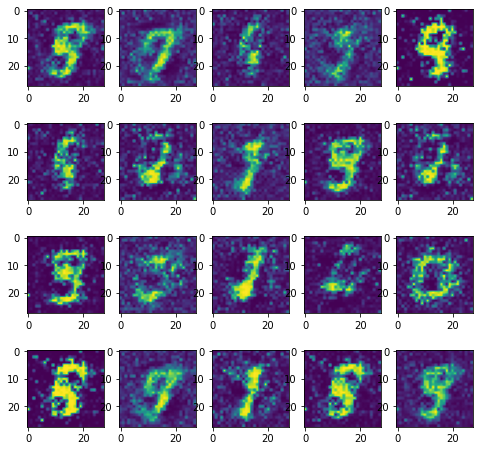

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  a = np.reshape(gen_imgs[i-1], (28,28))
  plt.imshow(a)
plt.show()

# Extra

In [ ]:
noise = np.random.normal(0, 1, (64, 100))
gen_imgs = gan.generator.predict(noise)
g_loss_discrimination = -np.linalg.norm(gen_imgs)
g_loss_discrimination

-43.594784